<a href="https://colab.research.google.com/github/shrutikamokashi/Amazon-Reviews-for-Sentiment-Analysis/blob/master/Amazon_dev_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Team: EAI 6000 (Winter 2020) : Capstone Project

*    Shrutika Mokashi
*    Yashmi Sevak
*    Janaki Sajja

### Last week link description: 
•	Initially while submitting last week’s project initial report, our topic that we submitted was ‘Sentiment Analysis Using Twitter Data’ and we had created a developer account and waiting for twitter to approve it. But unfortunately, we did not receive any kind of response from them and so we choose to keep the methodology and techniques same but use Amazon review data for out Sentiment Analysis.

## Hands on sentiment analysis

Project Description- We are implementing Sentiment Analysis using Amazon reviews. We are using datasets to fetch data and implement text segmentation using NLP. The text is the reviews and it will be divided into positive, negative and neutral review also. Using various models, our goal is finding the best accuracy using a best fit model.

Team: EAI 6000 (Capstone Project)

1. Shrutika Mokashi
2. Yashmi Sevak
3. Janaki Sajja

# What is Sentiment Analysis? And why?

Analysis of emotion is omnipresent, and is a method of classification based on natural language processing. Judging whether a sentence (or article) is positive or negative is the key problem to be solved. 
Dealing with an sentiment can significantly enhance people's perception of situations, and can also use the results of an analysis of feelings to benefit certain people or things.
For example,
Government should comprehend the feeling of people against some events to maintain peace. Consequently, they are able to understand the nature of public opinion and perform timely and efficient monitoring of public opinion.

This dataset is made up of a few million Amazon customer reviews (text input) and star ratings (labels output) to learn how to train fastText for sentiment analysis.

*   Content:
The fastText supervised learning tutorial requires data in the following format:
__label__<X> __label__<Y> ... <Text>
where X and Y are the class names. No quotes, all on one line.

*   In this case, the classes are 
1. __label__1 : corresponds to 1- and 2-star reviews
2. __label__2 : corresponds to 4- and 5-star reviews

3. 3-star reviews i.e. reviews with neutral sentiment were not included in the original
*   There is only one class per row.
*   The review titles, followed by ':' and a space, are prepended to the text.

*   Most of the reviews are in English, but there are a few in other languages, like Spanish.

*   Source: The data was lifted from Xiang Zhang's Google Drive, in .csv format, which was not suitable for fastText.

*   To train: ./fasttext supervised -input train.ft.txt -output model_amzn
*   To test: ./fasttext test model_amzn.bin test.ft.txt

We can also train and test in Python, but we used datasets provided at below link,

https://www.kaggle.com/bittlingmayer/amazonreviews

which were in given i.e. fastText format.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
#import tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Instructions for updating:
non-resource variables are not supported in the long term


## Reading the text

The wording is in a simplified format. The first word gives the mark, so we need to translate that to a number and then take the rest as the statement.

In [0]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd 'drive/My Drive/python'

/content/drive/My Drive/python


In [0]:
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')

## Text Preprocessing
The first thing we must do to process the text is to lower it all, and then delete non-word characters. I replace these with spaces as most would be punctuation. Then I'll only delete any other characters.

It would be easier to replace some of these with standard ascii characters but here I will just overlook that. This also points out that there are very few uncommon characters in this corpus, if you look at the counts of the various characters.

In [0]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [7]:
train_texts

['stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    ',
 'the best soundtrack ever to anything   i m reading a lot of reviews saying that this is the best  game soundtrack  and i figured that i d write a review to disagree a bit  this in my opinino is yasunori mitsuda s ultimate masterpiece  the music is timeless and i m been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth every penny ',
 'amazing   this soundtrack is my favorite music of all 

## Train/Validation Split
We are setting aside 20% of the training set for validation.

In [0]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=57643892, test_size=0.2)

Keras provides some tools for converting text to formats that are useful in deep learning models. Now we are running a Tokenizer using the top 12000 words as features.

In [0]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

## Padding Sequences
To efficiently use sets, we would need to take the sequences and convert them into the same-length sequences. I would only make it the longest sentence in the training package here.

In [0]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

## Convolutional Neural Net Model

CNN has a 64, 3-layer embedding with the first two matching normalization and max pooling and the last one with regional max pooling. Afterwards the results are transferred to a dense layer and then the output.

In [11]:
def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
  history_cnn = model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=4,
    validation_data=(val_texts, val_labels), )

Train on 2880000 samples, validate on 720000 samples
Epoch 1/4
2880000/2880000 [==============================] - 313s 109us/sample - loss: 0.1679 - binary_accuracy: 0.9362 - val_loss: 0.1473 - val_binary_accuracy: 0.9453
Epoch 2/4
2880000/2880000 [==============================] - 306s 106us/sample - loss: 0.1449 - binary_accuracy: 0.9467 - val_loss: 0.1399 - val_binary_accuracy: 0.9482
Epoch 3/4
2880000/2880000 [==============================] - 307s 107us/sample - loss: 0.1393 - binary_accuracy: 0.9492 - val_loss: 0.1431 - val_binary_accuracy: 0.9486
Epoch 4/4
2880000/2880000 [==============================] - 307s 107us/sample - loss: 0.1367 - binary_accuracy: 0.9504 - val_loss: 0.1438 - val_binary_accuracy: 0.9479


In [13]:
history_cnn.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

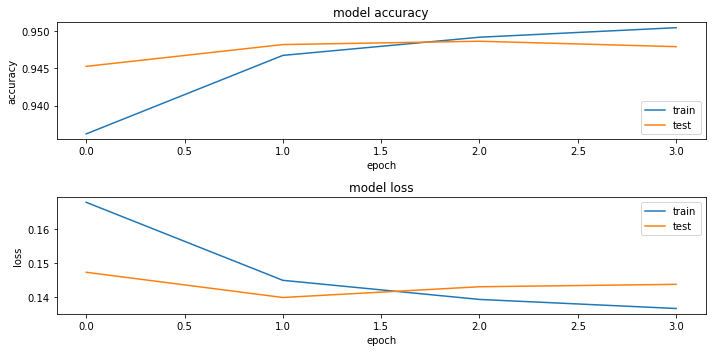

In [14]:
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(history_cnn.history['binary_accuracy'])
plt.plot(history_cnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Once this finishes training, we should find that we get an accuracy of around 94% for this model.

In [15]:
preds = model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9475
F1 score: 0.9481
ROC AUC score: 0.9871


## Recurrent Neural Net Model
I'm going to use a basic model for an RNN model too. This has an embedding, two layers of GRU, followed by 2 dense layers and the output layer afterwards. I use CuDNNGRU instead of GRU because the former runs much faster.

In [0]:
def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
rnn_model = build_rnn_model()

In [17]:
history_rnn = rnn_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=4,
    validation_data=(val_texts, val_labels), )


Train on 2880000 samples, validate on 720000 samples
Epoch 1/4
2880000/2880000 [==============================] - 1037s 360us/sample - loss: 0.1607 - binary_accuracy: 0.9390 - val_loss: 0.1332 - val_binary_accuracy: 0.9506
Epoch 2/4
2880000/2880000 [==============================] - 1031s 358us/sample - loss: 0.1309 - binary_accuracy: 0.9523 - val_loss: 0.1299 - val_binary_accuracy: 0.9531
Epoch 3/4
2880000/2880000 [==============================] - 1034s 359us/sample - loss: 0.1264 - binary_accuracy: 0.9546 - val_loss: 0.1289 - val_binary_accuracy: 0.9532
Epoch 4/4
2880000/2880000 [==============================] - 1033s 359us/sample - loss: 0.1249 - binary_accuracy: 0.9553 - val_loss: 0.1327 - val_binary_accuracy: 0.9524


And we should find that this model will end up with an accuracy similar to the CNN model.

In [18]:
preds = rnn_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9515
F1 score: 0.952
ROC AUC score: 0.9887


In [19]:
history_rnn.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

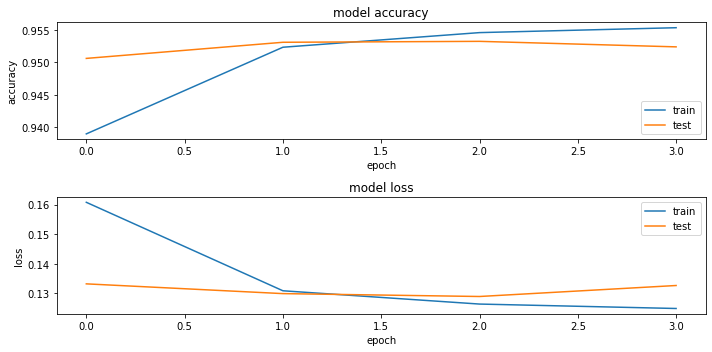

In [21]:
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(history_rnn.history['binary_accuracy'])
plt.plot(history_rnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()